## 01 Imports

In [35]:
import pythonlib.helpers as hlp
# General Imports
import numpy as np
from numpy.random import default_rng

# Visualisation Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, execute
from qiskit_machine_learning.datasets import ad_hoc_data

In [36]:
from importlib import reload
reload(hlp)

<module 'helpers' from '/Users/phuber/git/ZHAW/BA/pa_qml/helpers.py'>

## 02 Global Parameters

In [37]:
# FILES
DATASET_FILE = 'exp_out/datasets.data'
FEATUREMAP_FILE = 'exp_out/feature_maps.data'

# COMMON DATASET SETTINGS
NUMBER_DATASETS = 5
NUMBER_RUNS = 13
NUMBER_SAMPLES = 100
TEST_SIZE = 0.2

# CUSTOM dataset
rng = default_rng()
custom_fraktion_inside = 0.5 # fraktion of points lying inside of squre
custom_center = (3,3)
custom_innerR = 0.1
custom_outerR = 0.4
number_features_custom = 2

# IRIS dataset
iris_fraktion = 0.5
iris_number_points_label_0 = int(iris_fraktion*NUMBER_SAMPLES)
iris_number_points_label_1 = NUMBER_SAMPLES - iris_number_points_label_0
number_features_iris = 4
iris_feature_selector = [0,1,2,3] # select features 0,1,2,3

# ADHOC data set
ad_hoc_gap = 0.3
number_features_adhoc = 3
rep = 1

# RAIN data set
rain_fraktion = 0.5 # rainy vs. non rainy
number_samples_rain = int(rain_fraktion*NUMBER_SAMPLES)
number_samples_non_rain = NUMBER_SAMPLES - number_samples_rain

# VLDS data set
vlds_classes=1
number_features_vlds = 5
number_samples_vlds = NUMBER_SAMPLES

## 03 Helpers

In [38]:
'''
1. reshufle given data
2. split in test and train datasets, according to settings in global settings section
repeats process and creates 'number_runs' datasets
returns datasets
'''
def prepare_data(data, labels, number_runs=NUMBER_RUNS):
    # helper functions
    attach_column = lambda x,y: np.concatenate((x,np.reshape(y,(-1,1))),axis=1)
    reshufle = lambda x: resample(x, n_samples=NUMBER_SAMPLES, replace=False)
    # reshufle and split, normalize, ...
    reshufled = [reshufle(attach_column(data,labels)) for x in range(number_runs)]
    return [preprocess_data(x[:,:-1],x[:,-1]) for x in reshufled]

After splitting the data into train, validation, and test sets, the optimal approach is to first normalize the train set, then apply the mean and standard deviation of the train set normalization to the validation and test set normalization.
Source: https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb

In [39]:
'''
1. split
2. normalize
3. scale
'''
def preprocess_data(data, labels):
    sample_train, sample_test, label_train, label_test = train_test_split(
         data,labels, test_size=TEST_SIZE)

    # Normalise
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    
    return sample_train, sample_test, label_train, label_test

In [40]:
'''
returns sample_train, sample_test, label_train, label_test
'''
def split_data(data, labels):
    return  train_test_split(data,labels, test_size=TEST_SIZE, random_state=seed)

In [41]:
'''
Pair plots provided data.
Reference: https://seaborn.pydata.org/generated/seaborn.pairplot.html
'''
def plot(data,lables,title,remap_labels=None):
    id = lambda x: "feature-" + str(x)
    cols = ([id(i+1)for i in range(data.shape[1])])
    cols += ['labels']

    df = pd.DataFrame(np.hstack((data,lables.reshape(-1,1))), columns=cols) # merging labales under one df
    cols = ['feature-1', 'feature-2']
    pp = sns.pairplot(df, height=1.8, aspect=1.8,
                      plot_kws=dict(edgecolor="k", linewidth=0.5),
                      diag_kind='kde', diag_kws=dict(shade=True),hue='labels', markers=["o", "s"])
    fig = pp.fig 
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle(title, fontsize=14)

In [42]:
'''
prepends: global set-id and given label
[[0, 'custom', (array([...]), array([...]), array([...]), array([...]))],
e.g.,
'''
def add_set_label(label,data_sets):
    result = []
    for x in data_sets:
        result.append([add_set_label.set_id,label,x])
        add_set_label.set_id +=1
    return result
add_set_label.set_id = 0

## 04 Datasets

### 04.1 Custom Dataset

2 features

In [43]:
'''
Custom data set generator.
Points inside of the square.
Points ouside of the squre.
center - centers of two concetric squres.
Two feature data point.
numberPoints - number of generated points
x is choosen, y deppending on x has two cases.
'''
def custom_dataset_generator(numberPoints,center,innerR,outerR):
    line1 = lambda x: (x+center[1]-center[0])
    line2 = lambda x: (-x+center[1]+center[0])
    innerX = [center[0]-innerR,center[0]+innerR]
    innerY = [center[1]-innerR,center[1]+innerR]
    
    outerYTop = [center[1]+innerR,center[1]+outerR] 
    outerYBot = [center[1]-outerR,center[1]-innerR]
    outerX = [center[0]-outerR,center[0]+outerR]
    outerY = [center[1]-outerR,center[1]+outerR]
    
    x = np.array([])
    y = np.array([])
    l = np.array([])
    
    nPointInside = numberPoints*custom_fraktion_inside
    nPointOutside = numberPoints - nPointInside
    print(y)
    for i in range(int(nPointInside)):
        rn = rng.uniform(1,4) # by setting 0, will include center square
        l = np.append(l,0)
        if int(rn)== 0:#put in center
            x_rn = rng.uniform(innerX[0],innerX[1])
            x = np.append(x,x_rn)
            y = np.append(y,rng.uniform(innerY[0],innerY[1]))
        elif int(rn) == 1:#put on the first line
            x_rn = rng.uniform(outerX[0],outerX[1])
            x = np.append(x,x_rn)
            y = np.append(y,line1(x_rn))
        else:#put on the second line
            x_rn = rng.uniform(outerX[0],outerX[1])
            x = np.append(x,x_rn)
            y = np.append(y,line2(x_rn))
        
    for i in range(int(nPointOutside)):
        x = np.append(x,rng.uniform(outerX[0],outerX[1]))
        if( x[-1] < innerX[1] and x[-1] > innerX[0]):
            if rng.uniform() > 0.5:
                y = np.append(y,rng.uniform(outerYTop[0],outerYTop[1]))
            else:
                y = np.append(y,rng.uniform(outerYBot[0],outerYBot[1]))
        else:
            y = np.append(y,rng.uniform(outerY[0],outerY[1]))
        l = np.append(l,1)
    return np.stack((x,y),axis=1),np.uint(l)

[]


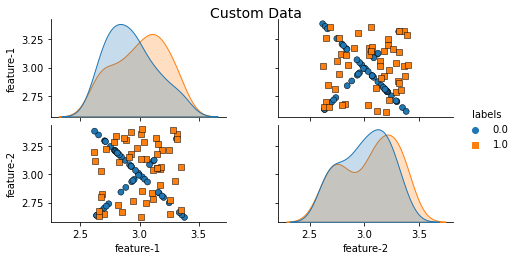

In [44]:
custom_data,custom_labels = custom_dataset_generator(NUMBER_SAMPLES,custom_center,custom_innerR,custom_outerR)
_=plot(custom_data,custom_labels,'Custom Data')

### 04.2 Iris Dataset

4 features

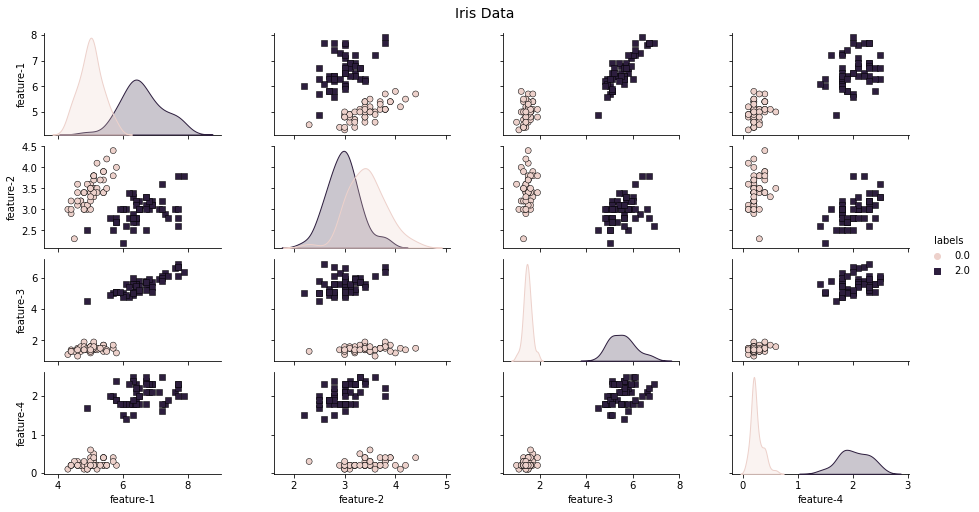

In [45]:
iris = datasets.load_iris()
# separating first and the last class
iris_data = np.concatenate((iris.data[:iris_number_points_label_0],iris.data[100:100+iris_number_points_label_1]))
iris_labels = np.concatenate((iris.target[:iris_number_points_label_0],iris.target[100:100+iris_number_points_label_1]))
iris_data = iris_data[:,iris_feature_selector] # for the case if less features are selected
plot(iris_data,iris_labels,'Iris Data')

Reploting with propper labels.

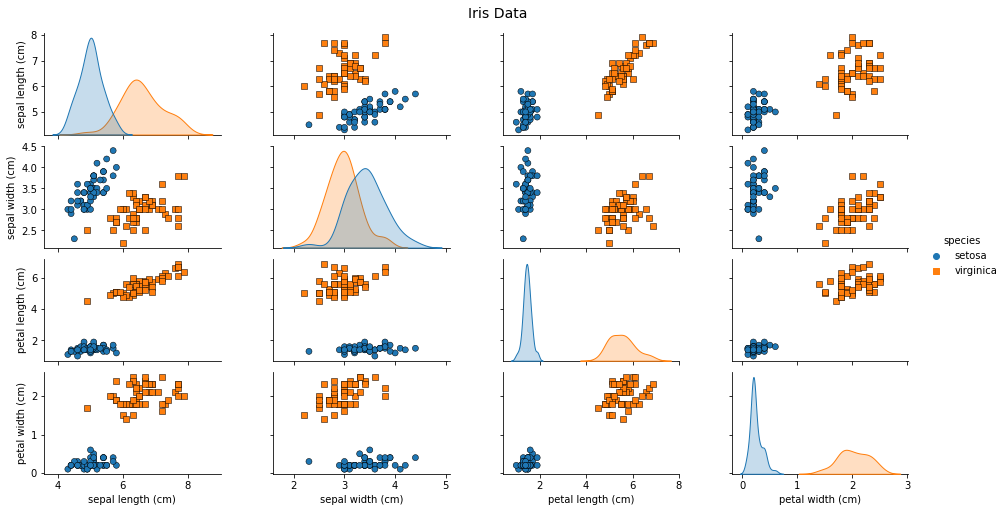

In [46]:
fr = datasets.load_iris(as_frame=True)['frame']
fr = fr.loc[(fr['target'] == 0) | (fr['target'] == 2)]
fr['target'] = fr['target'].replace(to_replace= [0, 1, 2], value = ['setosa', 'versicolor', 'virginica'])
fr = fr.rename({'target': 'species'}, axis=1) 
pp = sns.pairplot(fr,height=1.8, aspect=1.8,
             plot_kws=dict(edgecolor="k", linewidth=0.5), 
             diag_kind='kde', diag_kws=dict(shade=True), hue='species', markers=["o", "s"])
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle("Iris Data", fontsize=14)

In [47]:
fr.rename({'target': 'species'}, axis=1) 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### 04.3 Ad_hoc Dataset

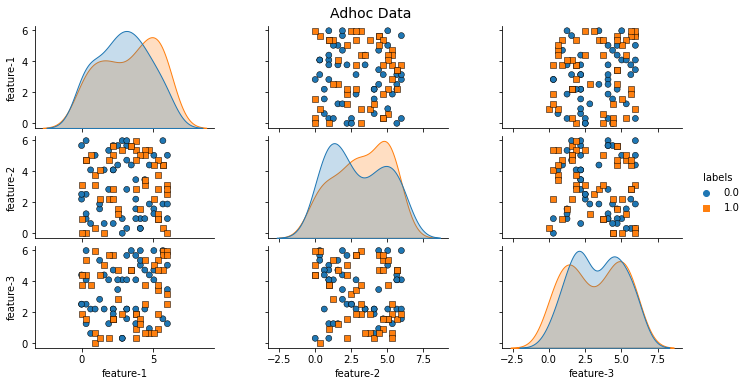

In [48]:
adhoc_data, adhoc_labels, _, _ = ad_hoc_data(training_size=int(0.5*NUMBER_SAMPLES),test_size=0,n=number_features_adhoc,gap=ad_hoc_gap,one_hot=False)
plot(adhoc_data,adhoc_labels,'Adhoc Data')

### 04.4 Rain Dataset

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Rain Data Set: rows containg N/A are gropped, randomly picked 5 features, labels tell if rain or not, then randomly selecte 50 rain and 50 non rainy rows.

In [49]:
data = pd.read_csv("exp_in/weatherAUS.csv") 

In [50]:
#data

In [51]:
df=data.dropna()

In [52]:
#df.keys()

In [53]:
mapping = dict(zip(list(df['WindDir9am'].value_counts().keys()),range(0, len(df['WindDir9am'].value_counts()))))

In [54]:
mapping2 = dict(zip(list(df['RainTomorrow'].value_counts().keys()),range(len(df['RainTomorrow'].value_counts().keys()))))

In [55]:
#df['WindDir9am'].map(mapping)

In [56]:
df_new = df[['MinTemp','Humidity9am','WindSpeed3pm','Pressure9am']].join(df['WindDir9am'].map(mapping)).join(df['RainTomorrow'].map(mapping2))

In [57]:
df_rain = df_new.loc[df_new['RainTomorrow']== 0].sample(n=number_samples_non_rain)#random sample

In [58]:
df_non_rain = df_new.loc[df_new['RainTomorrow']== 1].sample(n=number_samples_rain)

In [59]:
df = pd.concat([df_rain, df_non_rain])

In [60]:
assert NUMBER_SAMPLES == len(df['RainTomorrow'].to_numpy(dtype=np.uint8)), "Something wrong!"

In [61]:
df

,MinTemp,Humidity9am,WindSpeed3pm,Pressure9am,WindDir9am,RainTomorrow
142231,24.3,80.0,13.0,1012.8,2,0
87107,21.5,69.0,11.0,1017.0,3,0
136971,0.3,79.0,13.0,1021.7,5,0
85703,9.2,58.0,2.0,1019.6,9,0
65868,9.7,52.0,11.0,1016.2,9,0
...,...,...,...,...,...,...
75215,7.1,79.0,43.0,996.0,12,1
140074,23.3,94.0,26.0,1005.8,14,1
87925,23.0,90.0,19.0,1011.7,6,1
70107,9.6,97.0,9.0,1020.1,10,1


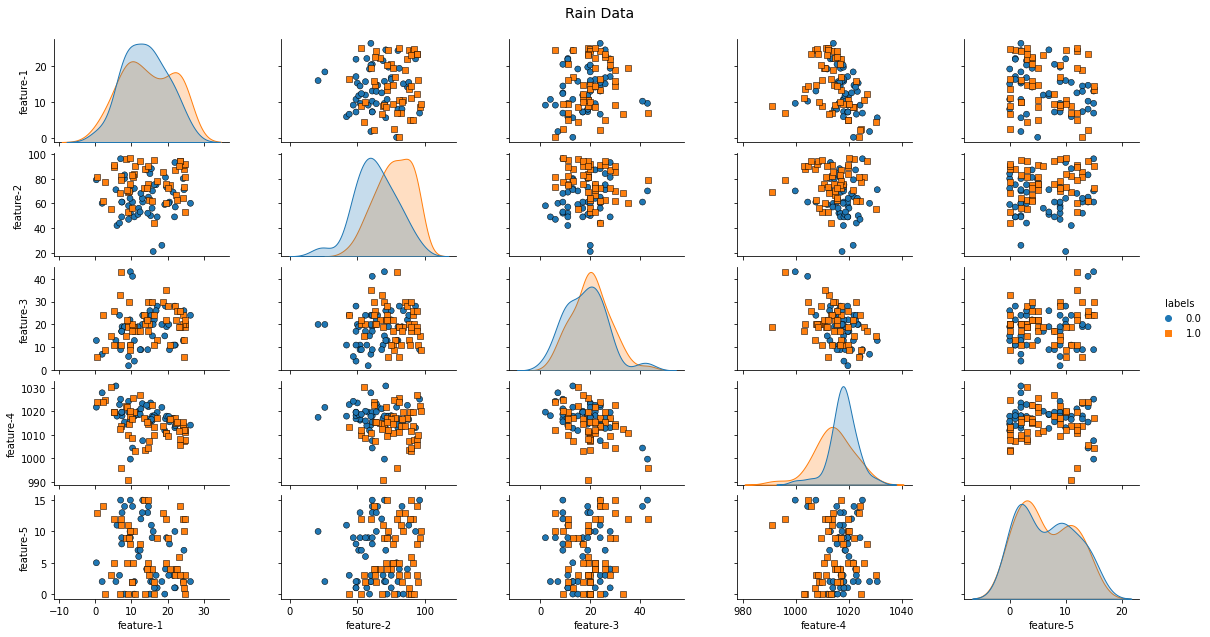

In [62]:
# separating first and the last class
rain_data = df.iloc[:,:-1].to_numpy(dtype=np.double)
rain_labels = df['RainTomorrow'].to_numpy(dtype=np.uint8)
plot(rain_data,rain_labels,'Rain Data')

Replotting the data, is not possible, due random sampling.

In [63]:
# df = pd.read_csv("weatherAUS.csv").dropna()
# df = df[['MinTemp','Humidity9am','WindSpeed3pm','Pressure9am','WindDir9am','RainTomorrow']]

In [64]:
# pp = sns.pairplot(df,height=1.8, aspect=1.8,
#              plot_kws=dict(edgecolor="k", linewidth=0.5), 
#              diag_kind='kde', diag_kws=dict(shade=True), hue='RainTomorrow', markers=["o", "s"])
# fig = pp.fig 
# fig.subplots_adjust(top=0.93, wspace=0.3)
# t = fig.suptitle("Rain Data", fontsize=14)

### 04.5 Very Last Data Set

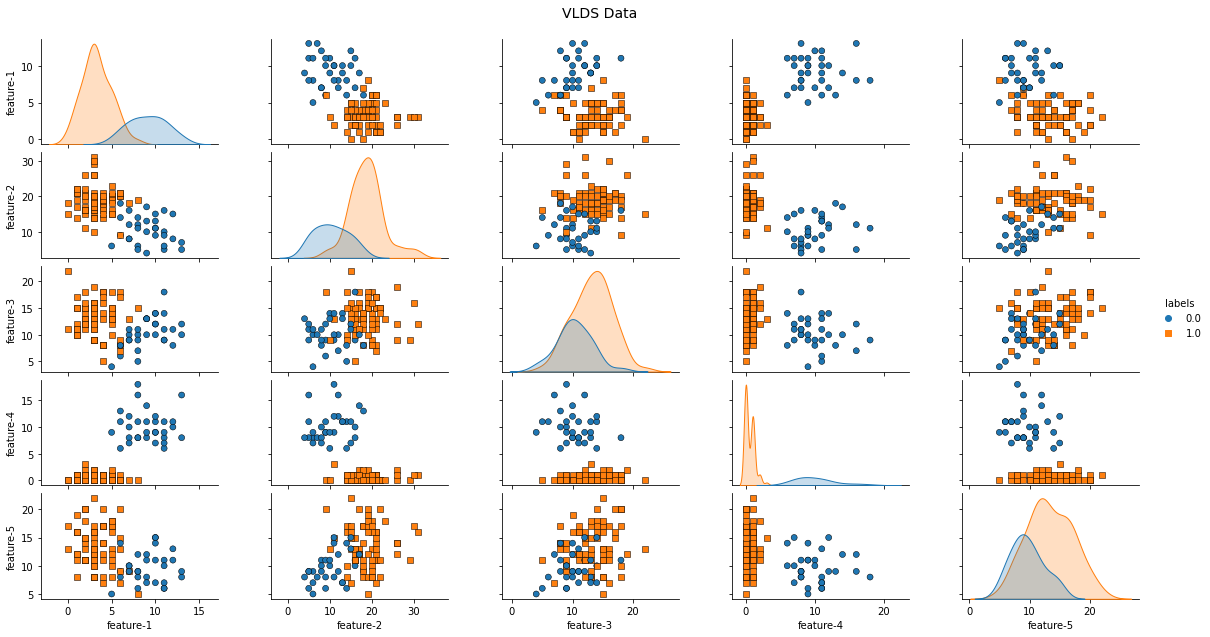

In [65]:
vlds=datasets.make_multilabel_classification(n_samples=NUMBER_SAMPLES,n_features=number_features_vlds,n_classes=vlds_classes)
vlds_data = vlds[0]
vlds_labels = vlds[1]
plot(vlds_data,vlds_labels,'VLDS Data')

## 05 Spliting and Preprocessing  and Storing Datasets

In [66]:
custom = add_set_label('custom',prepare_data(custom_data, custom_labels))
iris = add_set_label('iris',prepare_data(iris_data, iris_labels))
adhoc = add_set_label('adhoc',prepare_data(adhoc_data, adhoc_labels))
rain = add_set_label('rain',prepare_data(rain_data, rain_labels))
vlds = add_set_label('vlds',prepare_data(vlds_data, vlds_labels))
data_sets = custom + iris + adhoc + rain + vlds
hlp.store_data(data=data_sets,filename=DATASET_FILE)

In [67]:
hlp.verify_datasets_integrity(data_sets,number_datasets=NUMBER_DATASETS,
                              number_samples=NUMBER_SAMPLES,number_runs=NUMBER_RUNS)

### Generate Feature Maps

In [68]:
data = hlp.load_data(DATASET_FILE)
feature_maps = hlp.generate_feature_maps(data)

#print(feature_maps)
hlp.store_data(data=feature_maps,filename=FEATUREMAP_FILE)